In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor as xgb
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
%matplotlib inline
sns.set(rc={'figure.figsize':(18,6)})

In [2]:
TrainDataPath = 'yds_train2018.csv'
TestDataPath = 'yds_test2018.csv'
ExpenseDataPath = 'promotional_expense.csv'

# Loading the Training and Test Dataset
TrainData = pd.read_csv(TrainDataPath)
TestData = pd.read_csv(TestDataPath)
ExpenseData = pd.read_csv(ExpenseDataPath)

In [3]:
print("Training Dataset Shape:")
print(TrainData.shape)
print("\n")
print("Training Dataset Columns/Features:")
print(TrainData.dtypes)
TrainData.head()

Training Dataset Shape:
(79072, 8)


Training Dataset Columns/Features:
S_No             int64
Year             int64
Month            int64
Week             int64
Merchant_ID     object
Product_ID       int64
Country         object
Sales          float64
dtype: object


,S_No,Year,Month,Week,Merchant_ID,Product_ID,Country,Sales
0,1,2013,1,1,ar00001,1,Argentina,157500.0
1,2,2013,1,1,ar00003,1,Argentina,39375.0
2,3,2013,1,1,ar00004,1,Argentina,15750.0
3,4,2013,1,1,ar00007,1,Argentina,47250.0
4,5,2013,1,1,ar00008,1,Argentina,283500.0


In [4]:
print("Test Dataset Shape:")
print(TestData.shape)
print("\n")
print("Test Dataset Columns/Features:")
print(TestData.dtypes)
TestData.head()

Test Dataset Shape:
(105, 6)


Test Dataset Columns/Features:
S_No            int64
Year            int64
Month           int64
Product_ID      int64
Country        object
Sales         float64
dtype: object


,S_No,Year,Month,Product_ID,Country,Sales
0,79073,2016,4,1,Argentina,NaN
1,79074,2016,5,1,Argentina,NaN
2,79075,2016,6,1,Argentina,NaN
3,79076,2016,7,1,Argentina,NaN
4,79077,2016,8,1,Argentina,NaN


In [5]:
print("Expense Dataset Shape:")
print(ExpenseData.shape)
print("\n")
print("Expense Dataset Columns/Features:")
print(ExpenseData.dtypes)
ExpenseData.head()

Expense Dataset Shape:
(435, 5)


Expense Dataset Columns/Features:
Year               int64
Month              int64
Country           object
Product_Type       int64
Expense_Price    float64
dtype: object


,Year,Month,Country,Product_Type,Expense_Price
0,2013,1,Argentina,1,14749.307
1,2013,1,Argentina,2,1329.374
2,2013,1,Belgium,2,249.590
3,2013,1,Columbia,1,1893.122
4,2013,1,Columbia,2,1436.726


In [6]:
# checking missing data percentage in train data
total = TrainData.isnull().sum().sort_values(ascending = False)
percent = (TrainData.isnull().sum()/TrainData.isnull().count()*100).sort_values(ascending = False)
missing_TrainData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_TrainData.head(30)

,Total,Percent
Sales,0,0.0
Country,0,0.0
Product_ID,0,0.0
Merchant_ID,0,0.0
Week,0,0.0
Month,0,0.0
Year,0,0.0
S_No,0,0.0


In [7]:
# checking missing data percentage in test data
total = TestData.isnull().sum().sort_values(ascending = False)
percent = (TestData.isnull().sum()/TestData.isnull().count()*100).sort_values(ascending = False)
missing_TestData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_TestData.head(30)

,Total,Percent
Sales,105,100.0
Country,0,0.0
Product_ID,0,0.0
Month,0,0.0
Year,0,0.0
S_No,0,0.0


In [8]:
# checking missing data percentage in Expense data
total = ExpenseData.isnull().sum().sort_values(ascending = False)
percent = (ExpenseData.isnull().sum()/ExpenseData.isnull().count()*100).sort_values(ascending = False)
missing_ExpenseData  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_ExpenseData.head(30)

,Total,Percent
Expense_Price,0,0.0
Product_Type,0,0.0
Country,0,0.0
Month,0,0.0
Year,0,0.0


In [9]:
def train_test_data_check(train_df, test_df, cols=None, use_all_cols=True):
    if cols == None:
        if use_all_cols:
            train_cols = set(train_df.columns)
            test_cols = set(test_df.columns)
            cols = train_cols.intersection(test_cols)
        else:
            train_cols = set(train_df.select_dtypes(['object', 'category']).columns)
            test_cols = set(test_df.select_dtypes(['object', 'category']).columns)
            cols = train_cols.intersection(test_cols)
        
    for i, col in enumerate(cols):
        display(HTML('<h3><font id="'+ col + '-ttdc' + '" color="blue">' + str(i+1) + ') ' + col + '</font></h3>'))
        print("Datatype : " + str(train_df[col].dtype) )
        print(str(train_df[col].dropna().nunique()) + " unique " + col  + " in Train dataset")
        print(str(test_df[col].dropna().nunique()) + " unique " + col  + " in Test dataset")
        extra = len(set(test_df[col].dropna().unique()) - set(train_df[col].dropna().unique()))
        print(str(extra) + " extra " + col + " in Test dataset")
        if extra == 0:
            display(HTML('<h5><font color="green"> All values present in Test dataset also present in Train dataset for column ' + col + '</font></h5>'))
        else:
            display(HTML('<h5><font color="green">' + str(extra) + ' ' +  col + ' are not present in Train dataset which are in Test dataset</font></h5>'))

In [10]:
train_test_data_check(TrainData, TestData)

Datatype : object
6 unique Country in Train dataset
6 unique Country in Test dataset
0 extra Country in Test dataset


Datatype : int64
4 unique Year in Train dataset
3 unique Year in Test dataset
1 extra Year in Test dataset


Datatype : float64
7934 unique Sales in Train dataset
0 unique Sales in Test dataset
0 extra Sales in Test dataset


Datatype : int64
12 unique Month in Train dataset
12 unique Month in Test dataset
0 extra Month in Test dataset


Datatype : int64
5 unique Product_ID in Train dataset
5 unique Product_ID in Test dataset
0 extra Product_ID in Test dataset


Datatype : int64
79072 unique S_No in Train dataset
105 unique S_No in Test dataset
105 extra S_No in Test dataset


In [11]:
train_test_data_check(TrainData, ExpenseData)

Datatype : object
6 unique Country in Train dataset
6 unique Country in Test dataset
0 extra Country in Test dataset


Datatype : int64
4 unique Year in Train dataset
5 unique Year in Test dataset
1 extra Year in Test dataset


Datatype : int64
12 unique Month in Train dataset
12 unique Month in Test dataset
0 extra Month in Test dataset


# VISUALIZATION

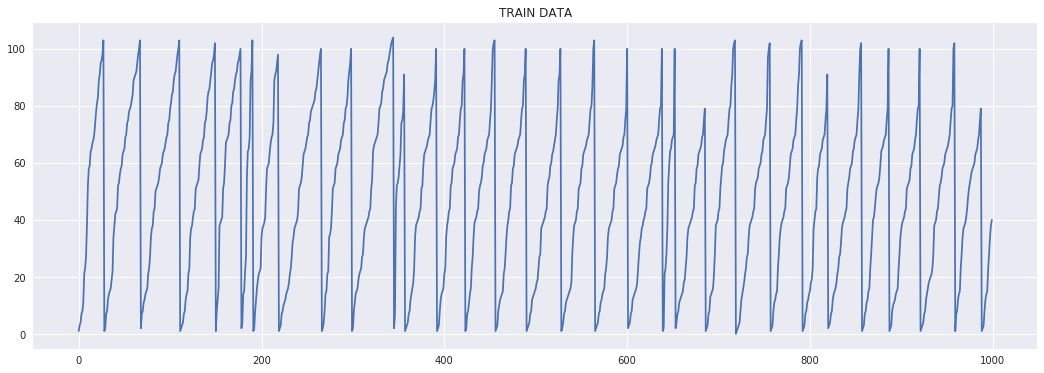

In [12]:
plt.figure(figsize=(18, 6))
plt.plot(TrainData["Merchant_ID"][:1000].str[6:].astype(int))
plt.title('TRAIN DATA')
plt.show()

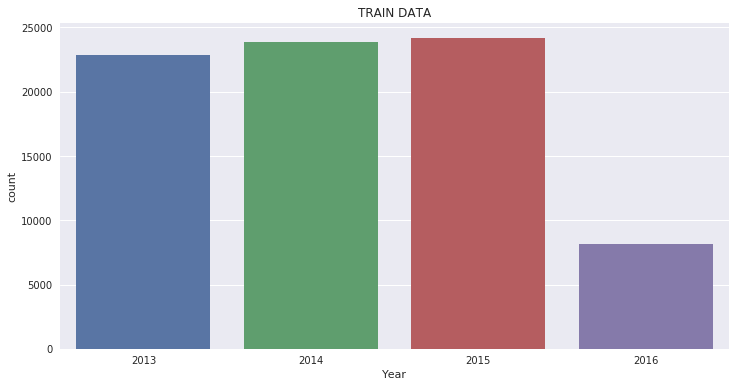

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(TrainData["Year"])
plt.title('TRAIN DATA')
plt.show()

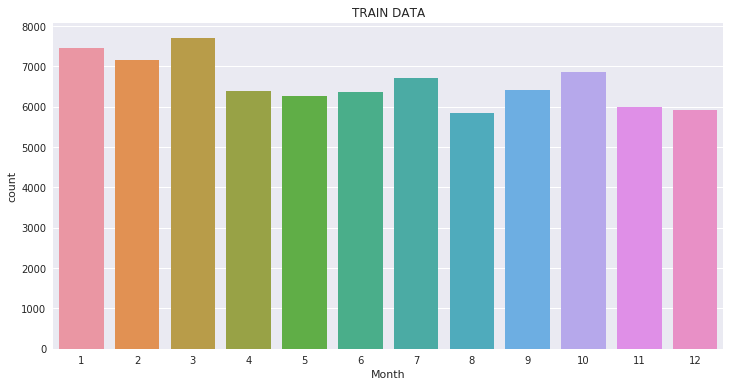

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(TrainData["Month"])
plt.title('TRAIN DATA')
plt.show()

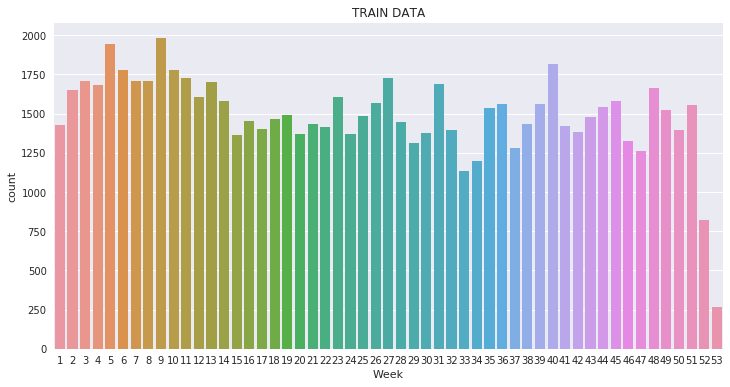

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(TrainData["Week"])
plt.title('TRAIN DATA')
plt.show()

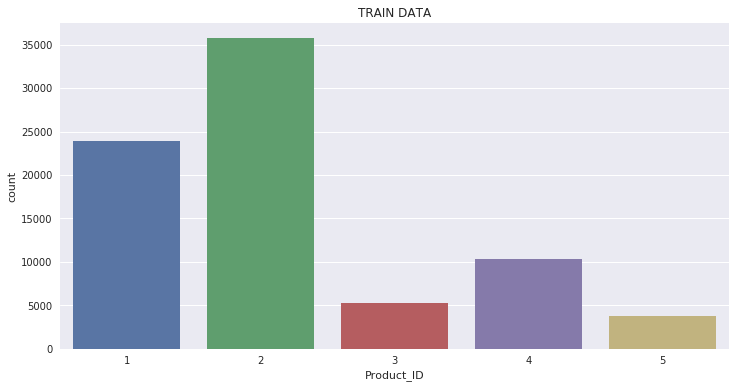

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(TrainData["Product_ID"])
plt.title('TRAIN DATA')
plt.show()

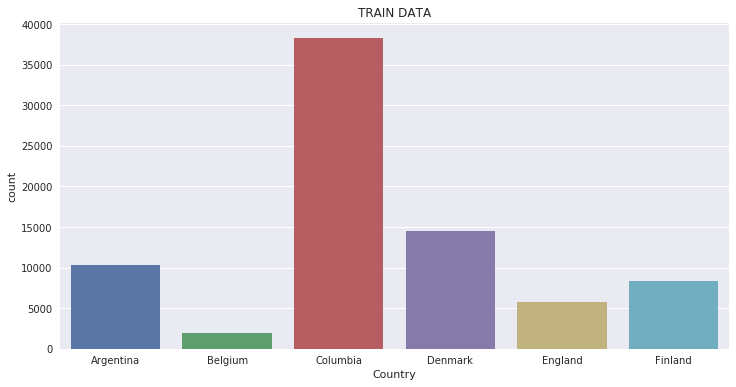

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(TrainData["Country"])
plt.title('TRAIN DATA')
plt.show()

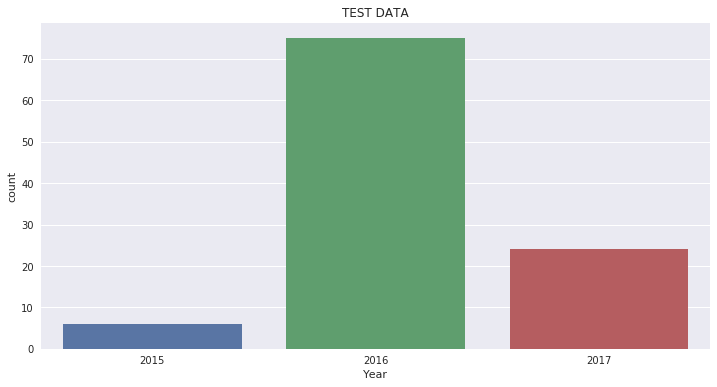

In [18]:
plt.figure(figsize=(12, 6))
sns.countplot(TestData["Year"])
plt.title('TEST DATA')
plt.show()

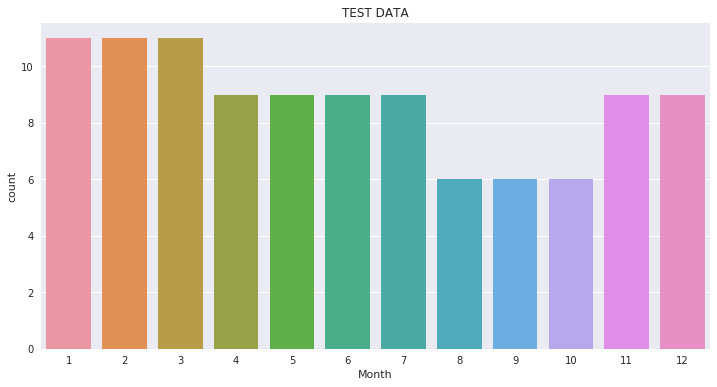

In [19]:
plt.figure(figsize=(12, 6))
sns.countplot(TestData["Month"])
plt.title('TEST DATA')
plt.show()

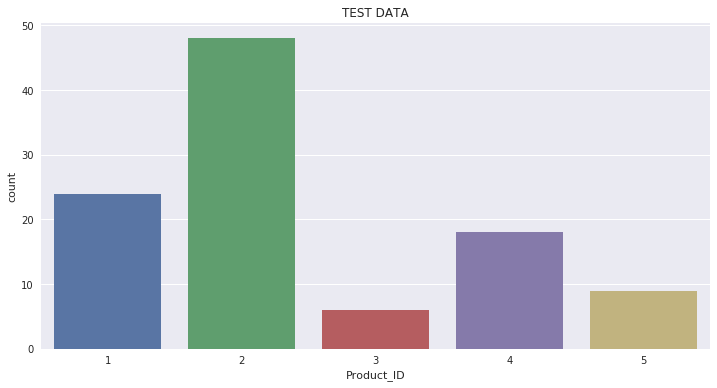

In [20]:
plt.figure(figsize=(12, 6))
sns.countplot(TestData["Product_ID"])
plt.title('TEST DATA')
plt.show()

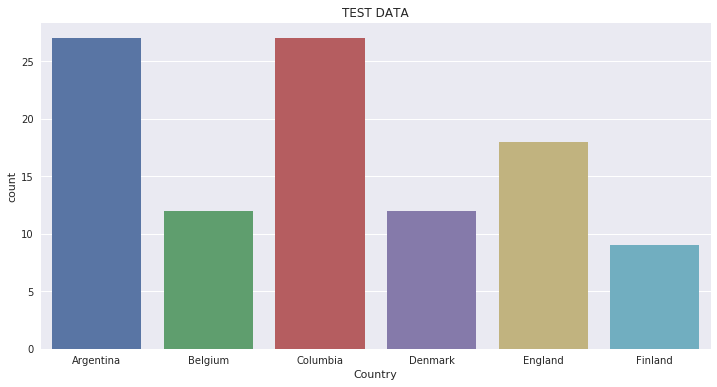

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(TestData["Country"])
plt.title('TEST DATA')
plt.show()

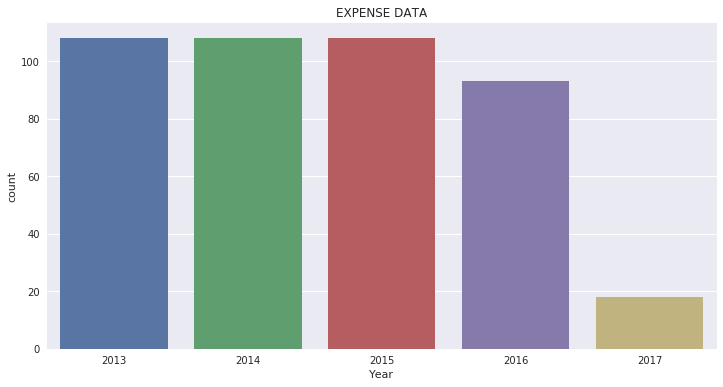

In [22]:
plt.figure(figsize=(12, 6))
sns.countplot(ExpenseData["Year"])
plt.title('EXPENSE DATA')
plt.show()

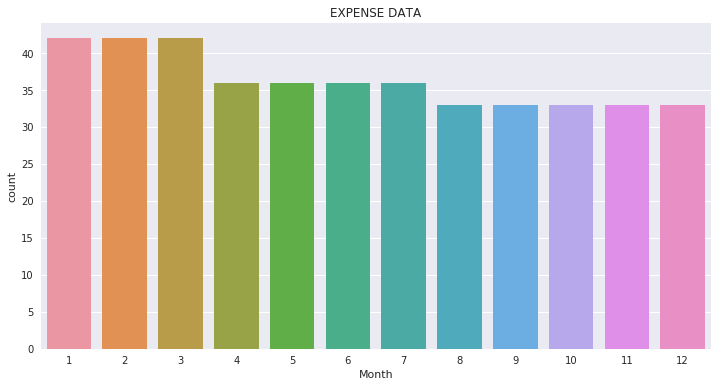

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(ExpenseData["Month"])
plt.title('EXPENSE DATA')
plt.show()

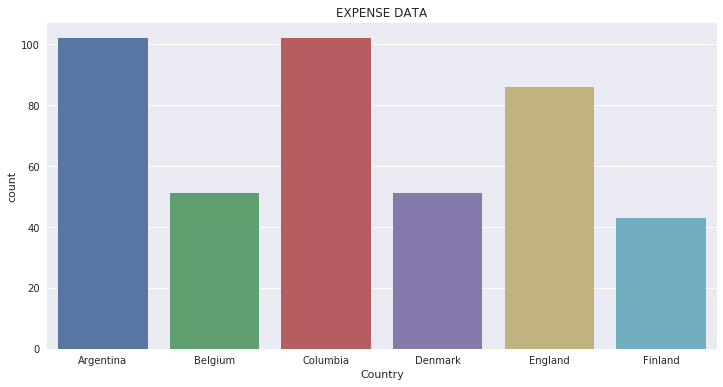

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(ExpenseData["Country"])
plt.title('EXPENSE DATA')
plt.show()

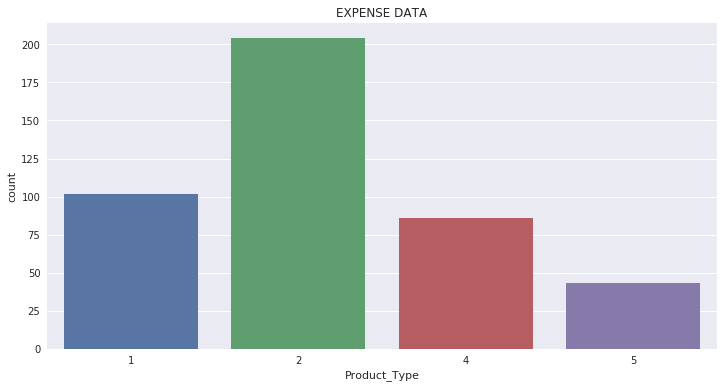

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(ExpenseData["Product_Type"])
plt.title('EXPENSE DATA')
plt.show()

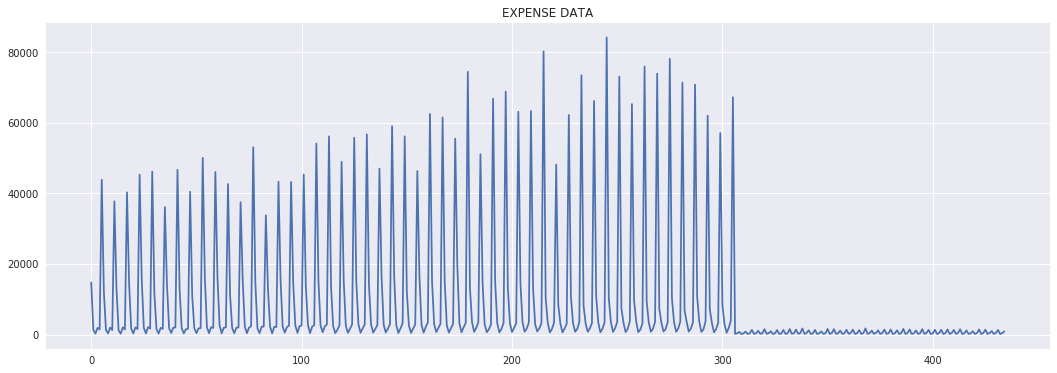

In [26]:
plt.figure(figsize=(18, 6))
plt.plot(ExpenseData["Expense_Price"])
plt.title('EXPENSE DATA')
plt.show()

# DATA MANIPULATION

In [27]:
df_Arg = ExpenseData[ExpenseData['Country'] == 'Argentina']
df_Bel = ExpenseData[ExpenseData['Country'] == 'Belgium']
df_Col = ExpenseData[ExpenseData['Country'] == 'Columbia']
df_Den = ExpenseData[ExpenseData['Country'] == 'Denmark']
df_Eng = ExpenseData[ExpenseData['Country'] == 'England']
df_Fin = ExpenseData[ExpenseData['Country'] == 'Finland']

Exp_Arg = df_Arg.groupby(['Product_Type','Year','Month'])['Expense_Price'].sum().reset_index(name = 'Expense_Price')
Exp_Bel = df_Bel.groupby(['Product_Type','Year','Month'])['Expense_Price'].sum().reset_index(name = 'Expense_Price')
Exp_Col = df_Col.groupby(['Product_Type','Year','Month'])['Expense_Price'].sum().reset_index(name = 'Expense_Price')
Exp_Den = df_Den.groupby(['Product_Type','Year','Month'])['Expense_Price'].sum().reset_index(name = 'Expense_Price')
Exp_Fin = df_Fin.groupby(['Product_Type','Year','Month'])['Expense_Price'].sum().reset_index(name = 'Expense_Price')
Exp_Eng = df_Eng.groupby(['Product_Type','Year','Month'])['Expense_Price'].sum().reset_index(name = 'Expense_Price')

Exp_Arg["Time"] = pd.to_datetime(Exp_Arg.Year*100+Exp_Arg.Month,format='%Y%m')
Exp_Bel["Time"] = pd.to_datetime(Exp_Bel.Year*100+Exp_Bel.Month,format='%Y%m')
Exp_Col["Time"] = pd.to_datetime(Exp_Col.Year*100+Exp_Col.Month,format='%Y%m')
Exp_Den["Time"] = pd.to_datetime(Exp_Den.Year*100+Exp_Den.Month,format='%Y%m')
Exp_Eng["Time"] = pd.to_datetime(Exp_Eng.Year*100+Exp_Eng.Month,format='%Y%m')
Exp_Fin["Time"] = pd.to_datetime(Exp_Fin.Year*100+Exp_Fin.Month,format='%Y%m')

Exp_Arg = Exp_Arg.set_index('Time')
Exp_Bel = Exp_Bel.set_index('Time')
Exp_Col = Exp_Col.set_index('Time')
Exp_Den = Exp_Den.set_index('Time')
Exp_Fin = Exp_Fin.set_index('Time')
Exp_Eng = Exp_Eng.set_index('Time')

Exp_Arg = Exp_Arg.drop(["Year","Month"],axis=1)
Exp_Bel = Exp_Bel.drop(["Year","Month"],axis=1)
Exp_Col = Exp_Col.drop(["Year","Month"],axis=1)
Exp_Den = Exp_Den.drop(["Year","Month"],axis=1)
Exp_Eng = Exp_Eng.drop(["Year","Month"],axis=1)
Exp_Fin = Exp_Fin.drop(["Year","Month"],axis=1)

In [28]:
df_Arg = TrainData[TrainData['Country'] == 'Argentina']
df_Bel = TrainData[TrainData['Country'] == 'Belgium']
df_Col = TrainData[TrainData['Country'] == 'Columbia']
df_Den = TrainData[TrainData['Country'] == 'Denmark']
df_Eng = TrainData[TrainData['Country'] == 'England']
df_Fin = TrainData[TrainData['Country'] == 'Finland']

Train_Arg = df_Arg.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Train_Bel = df_Bel.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Train_Col = df_Col.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Train_Den = df_Den.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Train_Fin = df_Fin.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Train_Eng = df_Eng.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')

Train_Arg["Time"] = pd.to_datetime(Train_Arg.Year*100+Train_Arg.Month,format='%Y%m')
Train_Bel["Time"] = pd.to_datetime(Train_Bel.Year*100+Train_Bel.Month,format='%Y%m')
Train_Col["Time"] = pd.to_datetime(Train_Col.Year*100+Train_Col.Month,format='%Y%m')
Train_Den["Time"] = pd.to_datetime(Train_Den.Year*100+Train_Den.Month,format='%Y%m')
Train_Eng["Time"] = pd.to_datetime(Train_Eng.Year*100+Train_Eng.Month,format='%Y%m')
Train_Fin["Time"] = pd.to_datetime(Train_Fin.Year*100+Train_Fin.Month,format='%Y%m')

Train_Arg = Train_Arg.set_index('Time')
Train_Bel = Train_Bel.set_index('Time')
Train_Col = Train_Col.set_index('Time')
Train_Den = Train_Den.set_index('Time')
Train_Fin = Train_Fin.set_index('Time')
Train_Eng = Train_Eng.set_index('Time')

Train_Arg = Train_Arg.drop(["Year","Month"],axis=1)
Train_Bel = Train_Bel.drop(["Year","Month"],axis=1)
Train_Col = Train_Col.drop(["Year","Month"],axis=1)
Train_Den = Train_Den.drop(["Year","Month"],axis=1)
Train_Eng = Train_Eng.drop(["Year","Month"],axis=1)
Train_Fin = Train_Fin.drop(["Year","Month"],axis=1)

In [29]:
df_Arg = TestData[TestData['Country'] == 'Argentina']
df_Bel = TestData[TestData['Country'] == 'Belgium']
df_Col = TestData[TestData['Country'] == 'Columbia']
df_Den = TestData[TestData['Country'] == 'Denmark']
df_Eng = TestData[TestData['Country'] == 'England']
df_Fin = TestData[TestData['Country'] == 'Finland']

Test_Arg = df_Arg.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Test_Bel = df_Bel.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Test_Col = df_Col.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Test_Den = df_Den.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Test_Fin = df_Fin.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')
Test_Eng = df_Eng.groupby(['Product_ID','Year','Month'])['Sales'].sum().reset_index(name = 'Sales')

Test_Arg["Time"] = pd.to_datetime(Test_Arg.Year*100+Test_Arg.Month,format='%Y%m')
Test_Bel["Time"] = pd.to_datetime(Test_Bel.Year*100+Test_Bel.Month,format='%Y%m')
Test_Col["Time"] = pd.to_datetime(Test_Col.Year*100+Test_Col.Month,format='%Y%m')
Test_Den["Time"] = pd.to_datetime(Test_Den.Year*100+Test_Den.Month,format='%Y%m')
Test_Eng["Time"] = pd.to_datetime(Test_Eng.Year*100+Test_Eng.Month,format='%Y%m')
Test_Fin["Time"] = pd.to_datetime(Test_Fin.Year*100+Test_Fin.Month,format='%Y%m')

Test_Arg = Test_Arg.set_index('Time')
Test_Bel = Test_Bel.set_index('Time')
Test_Col = Test_Col.set_index('Time')
Test_Den = Test_Den.set_index('Time')
Test_Fin = Test_Fin.set_index('Time')
Test_Eng = Test_Eng.set_index('Time')

Test_Arg = Test_Arg.drop(["Year","Month"],axis=1)
Test_Bel = Test_Bel.drop(["Year","Month"],axis=1)
Test_Col = Test_Col.drop(["Year","Month"],axis=1)
Test_Den = Test_Den.drop(["Year","Month"],axis=1)
Test_Eng = Test_Eng.drop(["Year","Month"],axis=1)
Test_Fin = Test_Fin.drop(["Year","Month"],axis=1)

In [30]:
Train_Arg.head()

,Product_ID,Sales
Time,,
2013-01-01,1,34346025.0
2013-02-01,1,32005575.0
2013-03-01,1,32530050.0
2013-04-01,1,35588700.0
2013-05-01,1,38789100.0


In [31]:
Test_Arg.head()

,Product_ID,Sales
Time,,
2016-04-01,1,0.0
2016-05-01,1,0.0
2016-06-01,1,0.0
2016-07-01,1,0.0
2016-08-01,1,0.0


In [32]:
Exp_Arg.head()

,Product_Type,Expense_Price
Time,,
2013-01-01,1,14749.307
2013-02-01,1,12187.566
2013-03-01,1,13076.579
2013-04-01,1,14377.199
2013-05-01,1,15652.861


# MORE REVEALING VISUALIZATION

In [33]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    plt.figure(figsize=(18,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

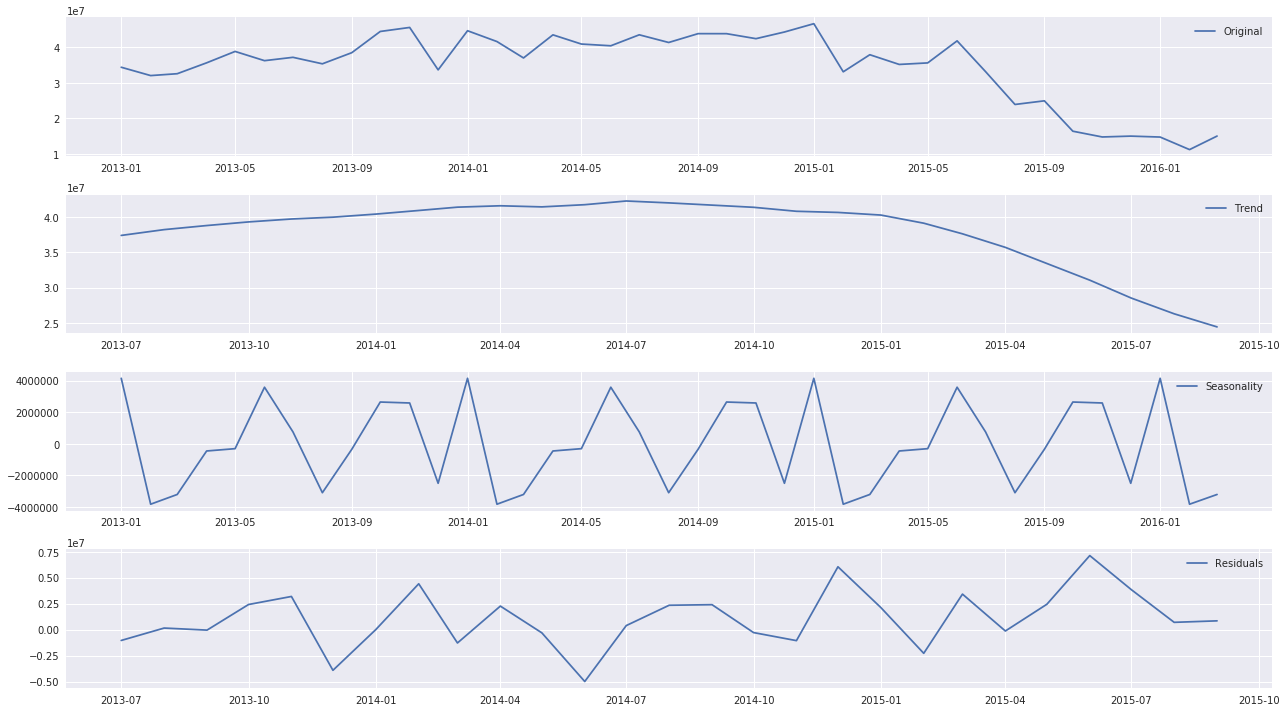

In [34]:
decomposition = seasonal_decompose(Train_Arg.query("Product_ID==1")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Arg.query("Product_ID==1")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

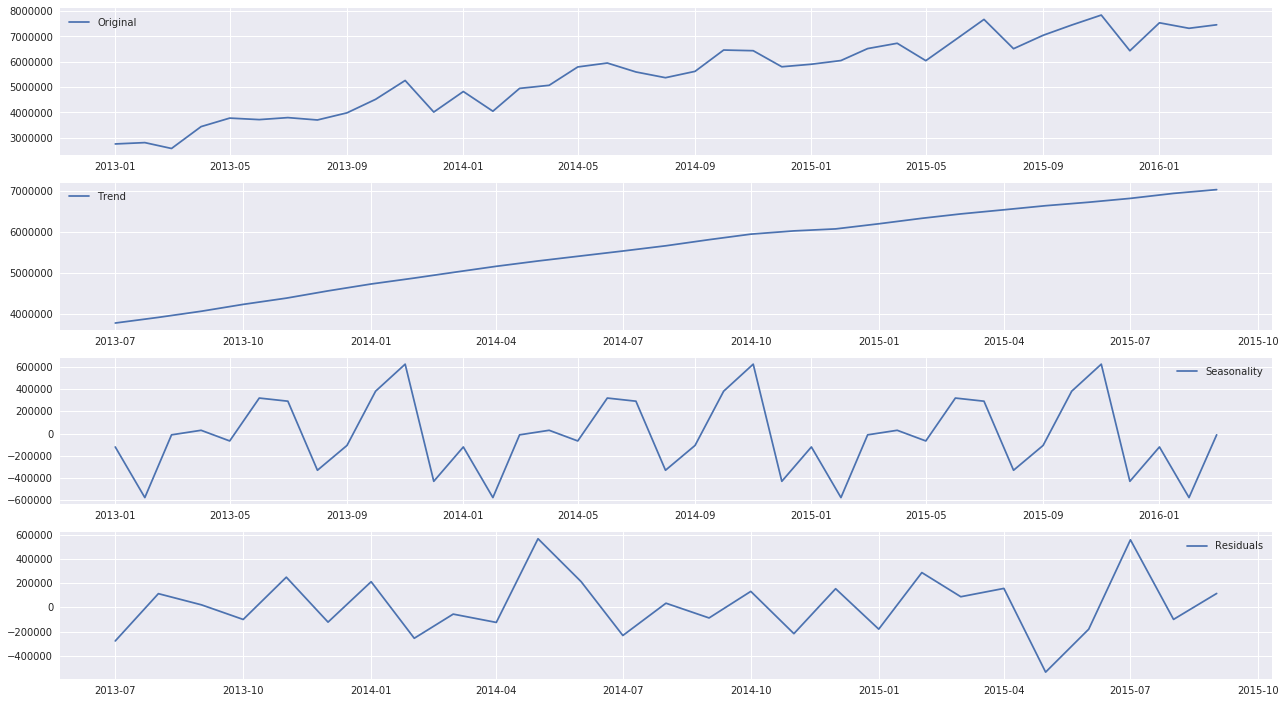

In [35]:
decomposition = seasonal_decompose(Train_Arg.query("Product_ID==2")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Arg.query("Product_ID==2")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

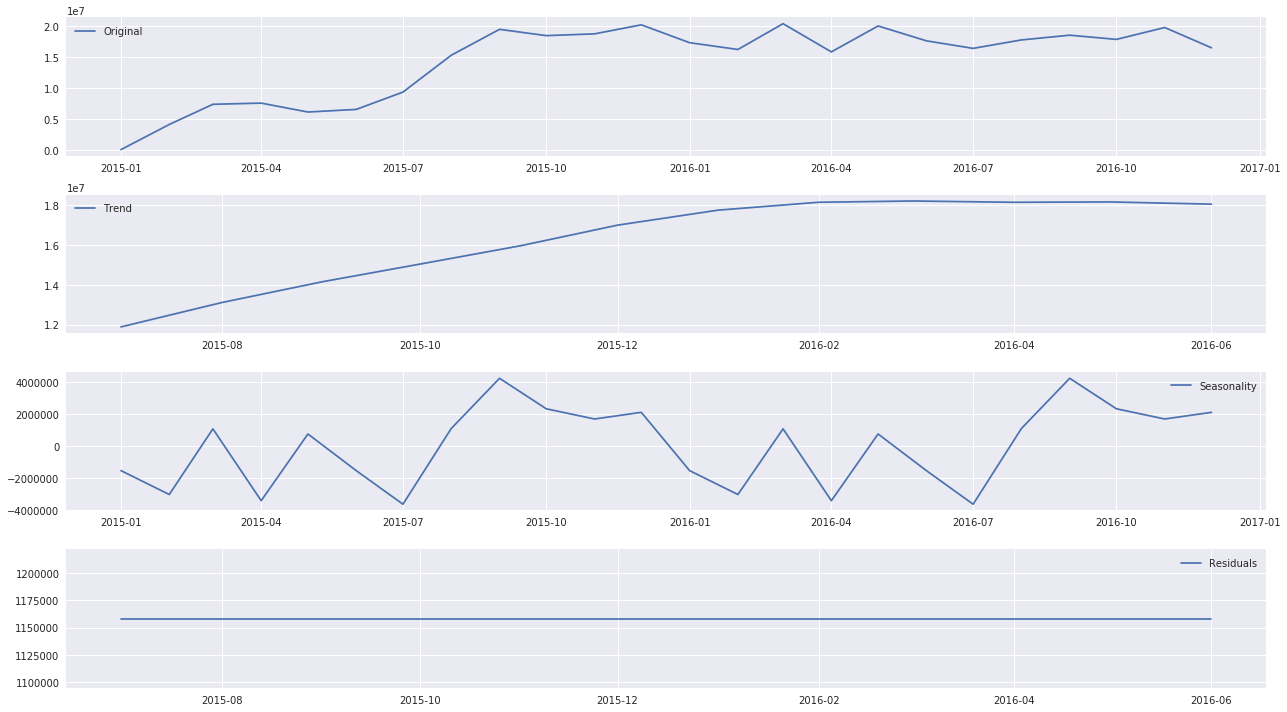

In [36]:
decomposition = seasonal_decompose(Train_Arg.query("Product_ID==3")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Arg.query("Product_ID==3")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

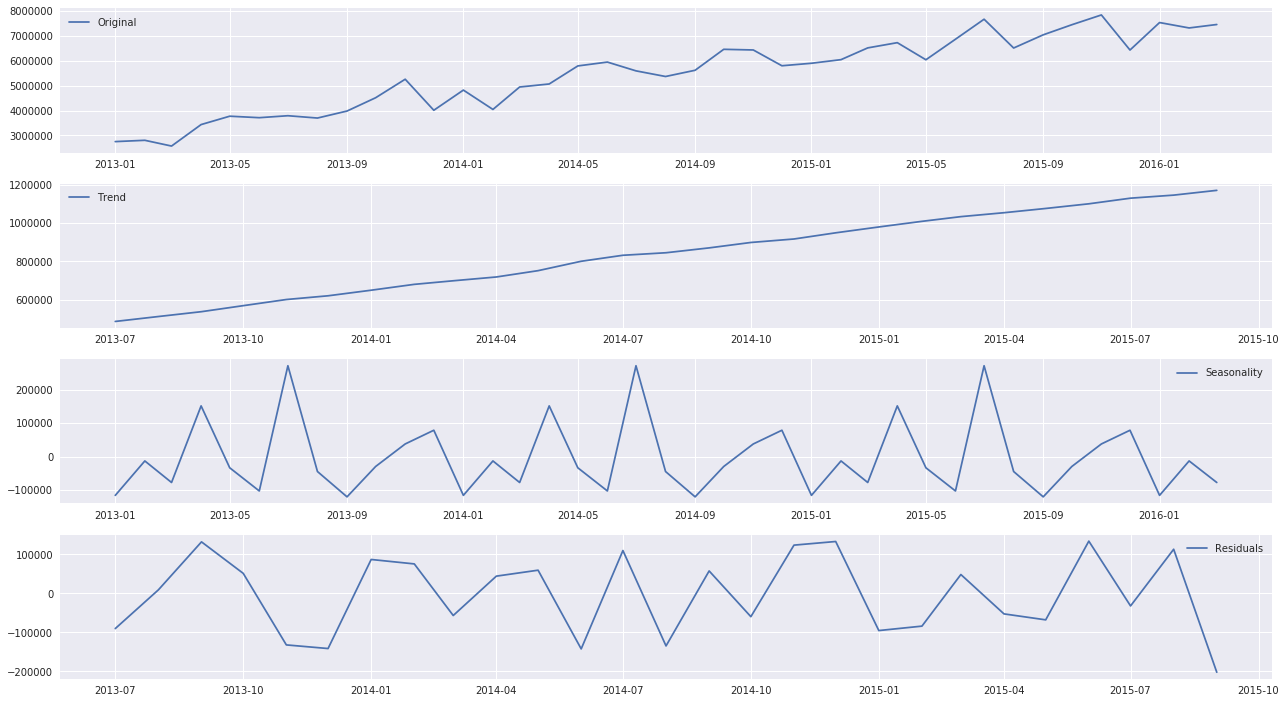

In [37]:
decomposition = seasonal_decompose(Train_Bel.query("Product_ID==2")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Arg.query("Product_ID==2")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

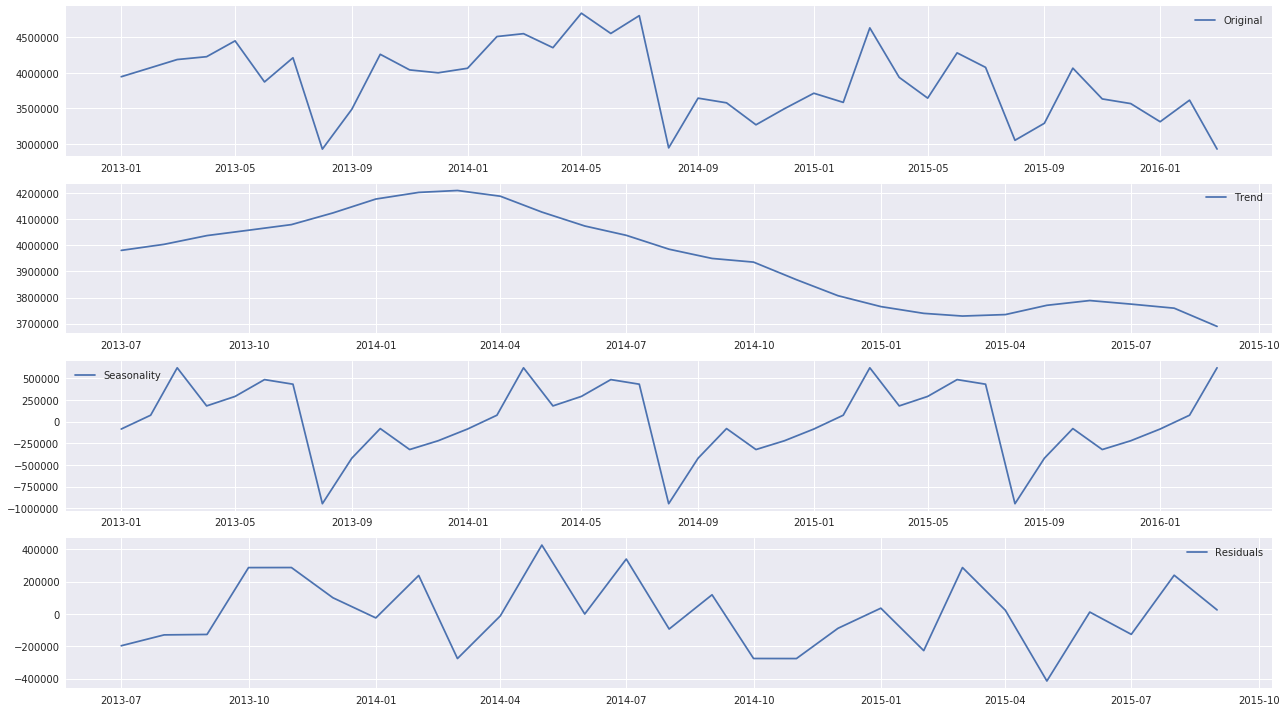

In [38]:
decomposition = seasonal_decompose(Train_Col.query("Product_ID==1")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Col.query("Product_ID==1")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

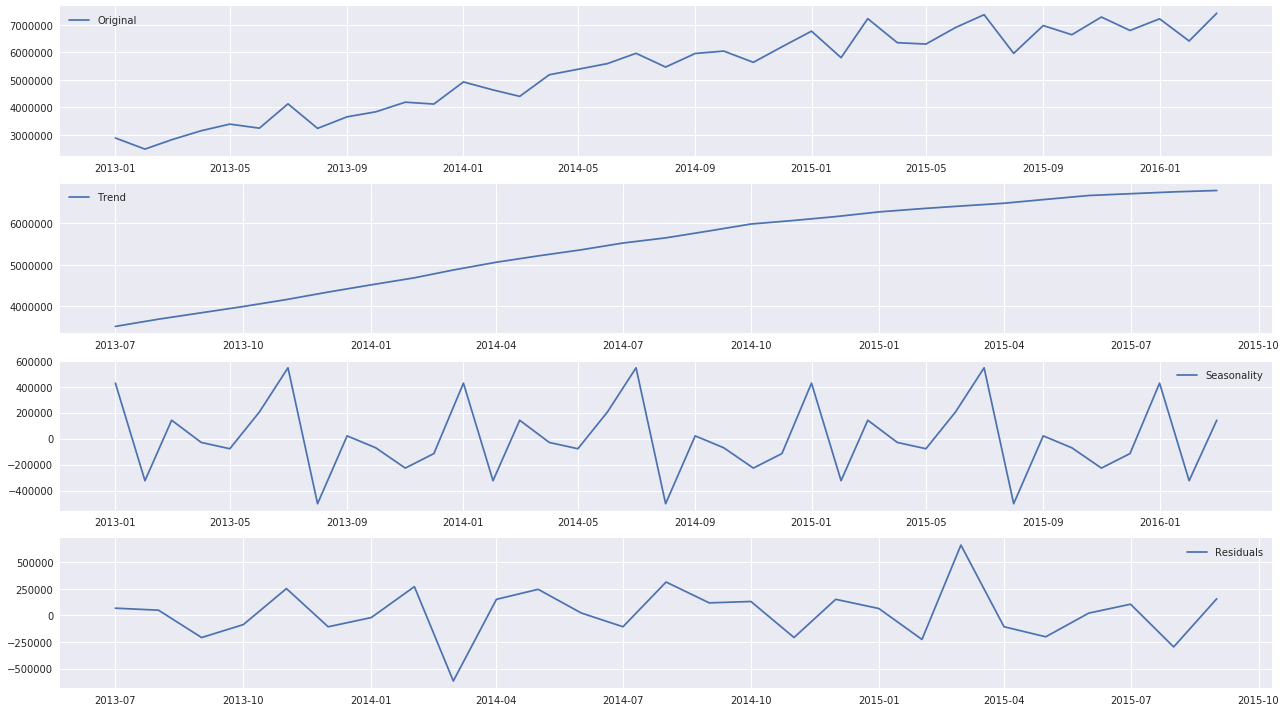

In [39]:
decomposition = seasonal_decompose(Train_Col.query("Product_ID==2")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Col.query("Product_ID==2")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

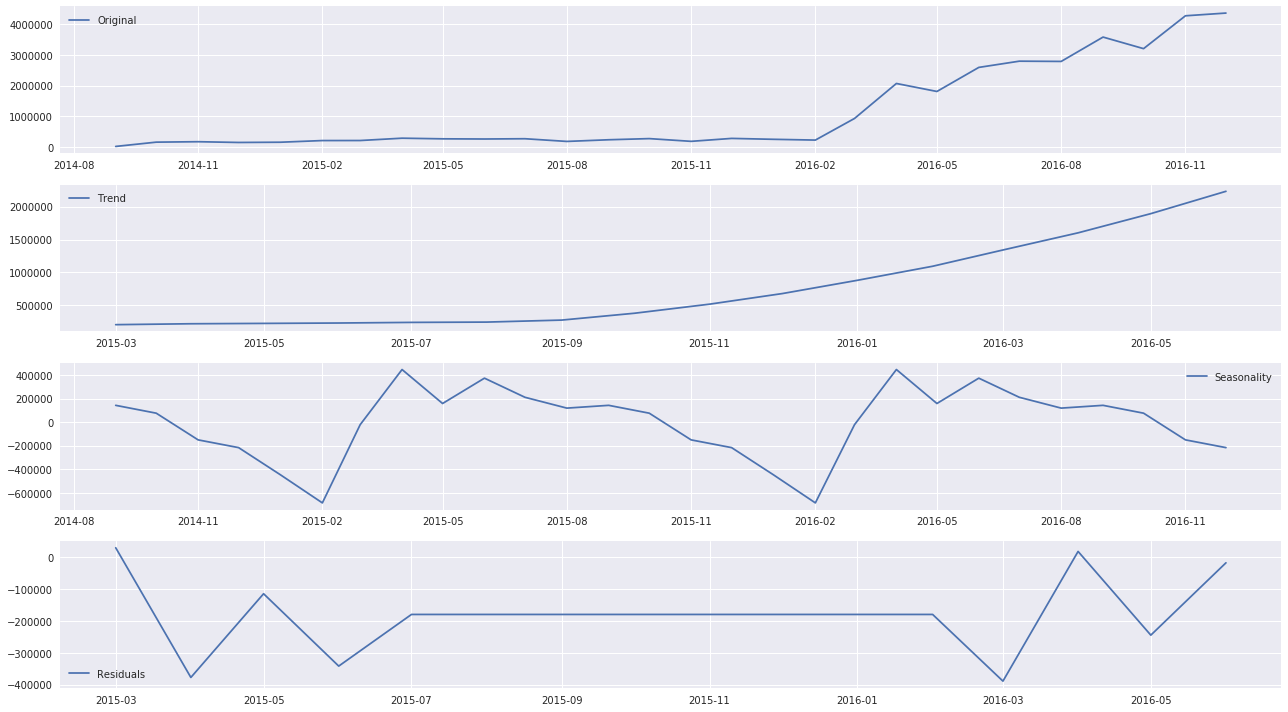

In [40]:
decomposition = seasonal_decompose(Train_Col.query("Product_ID==3")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Col.query("Product_ID==3")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

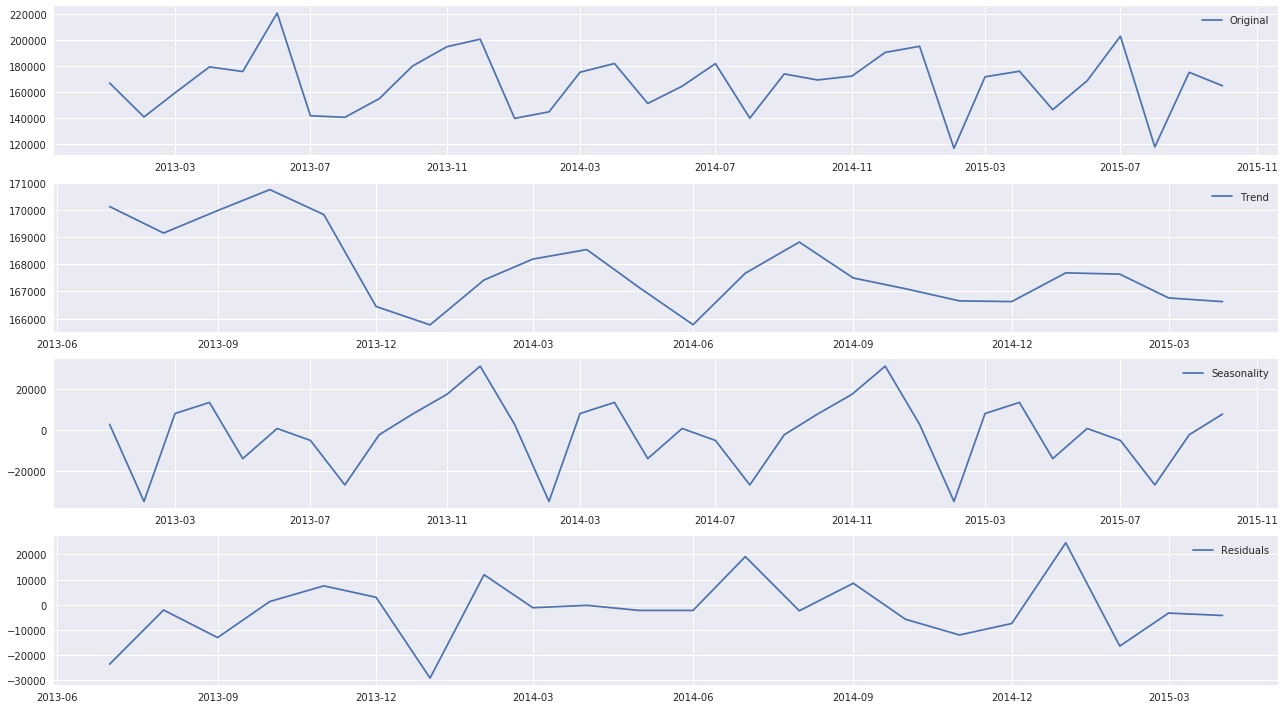

In [41]:
decomposition = seasonal_decompose(Train_Eng.query("Product_ID==4")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Eng.query("Product_ID==4")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

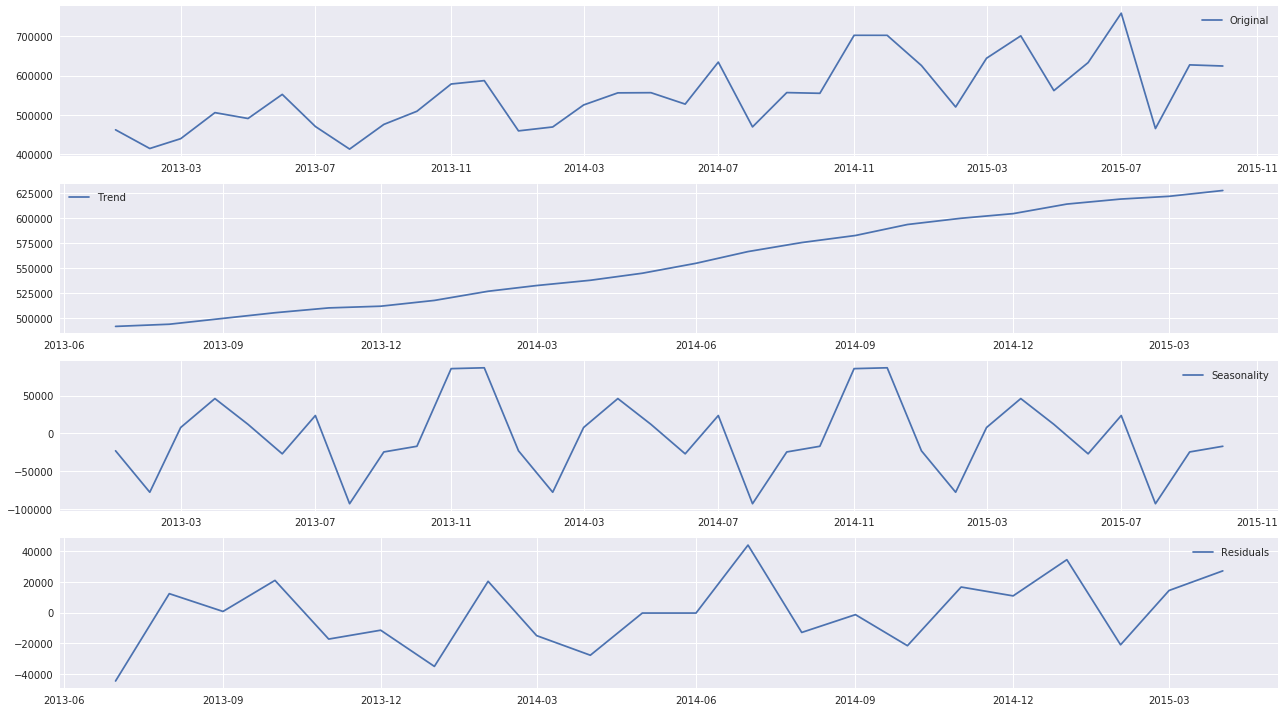

In [42]:
decomposition = seasonal_decompose(Train_Eng.query("Product_ID==5")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Eng.query("Product_ID==5")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

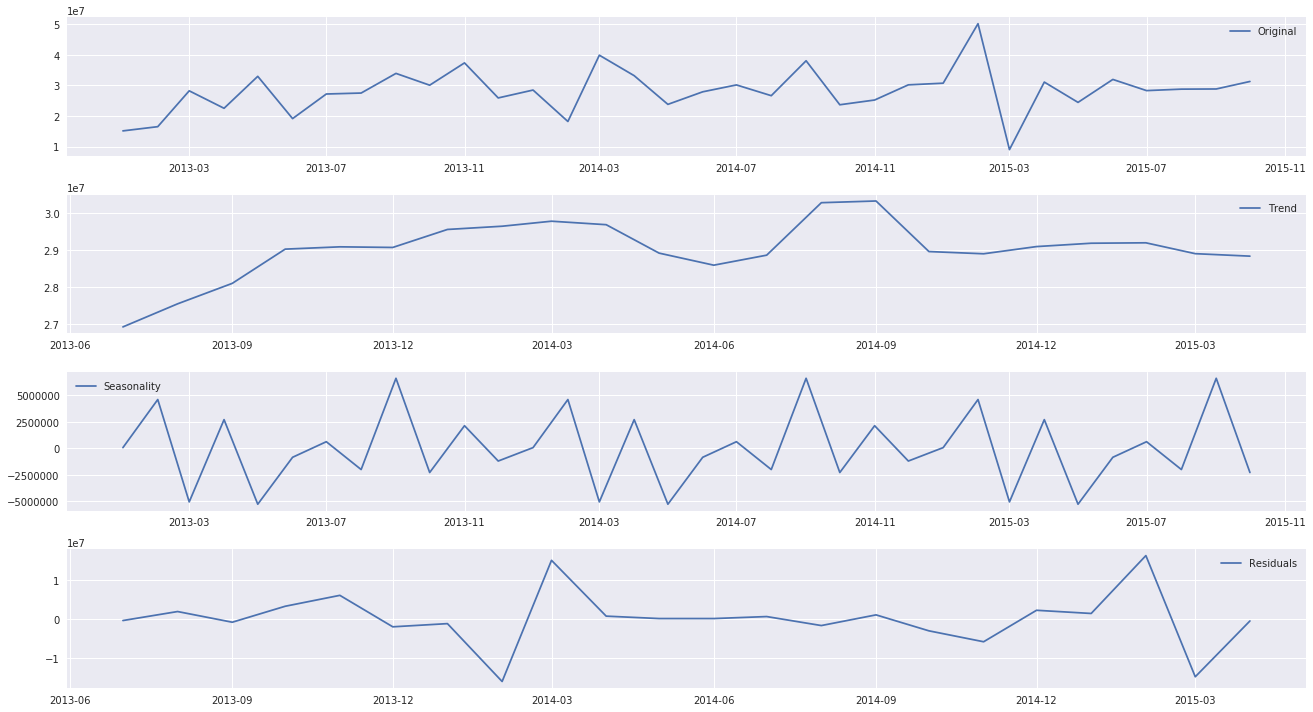

In [43]:
decomposition = seasonal_decompose(Train_Fin.query("Product_ID==4")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Fin.query("Product_ID==4")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

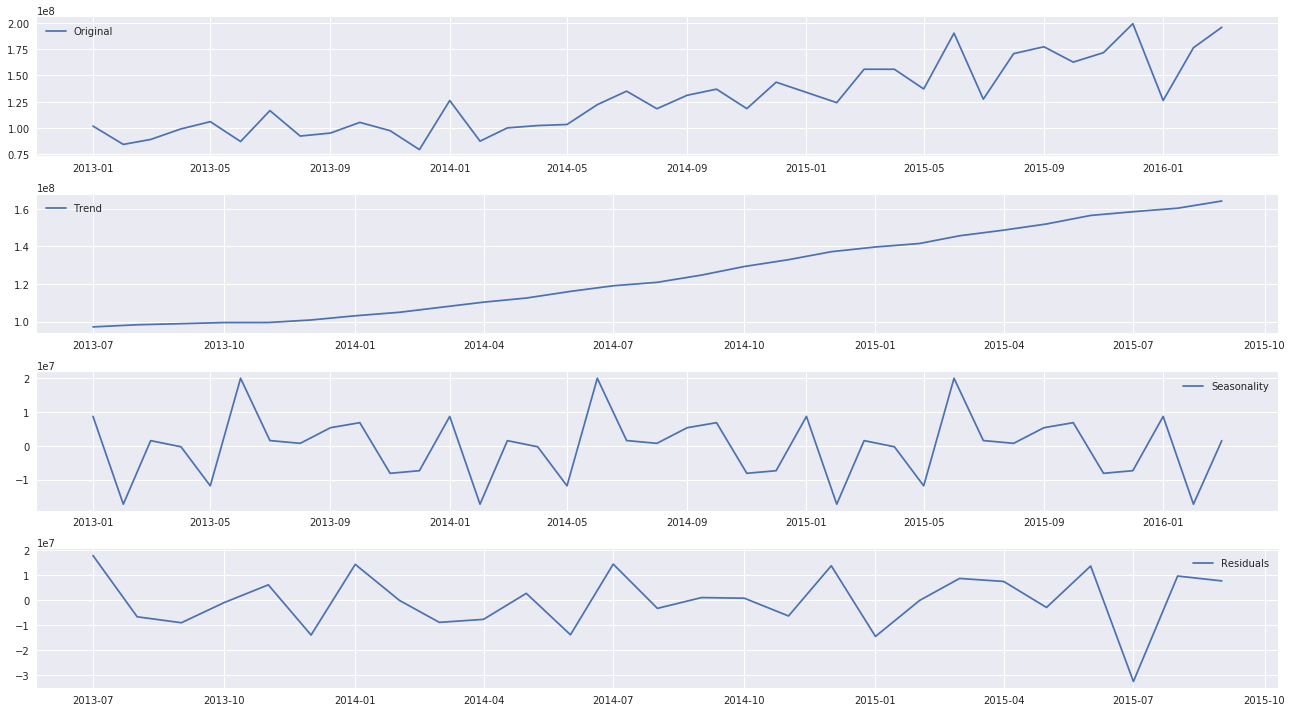

In [59]:
decomposition = seasonal_decompose(Train_Den.query("Product_ID==2")["Sales"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(18,10))
plt.subplot(411)
plt.plot(Train_Den.query("Product_ID==2")["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

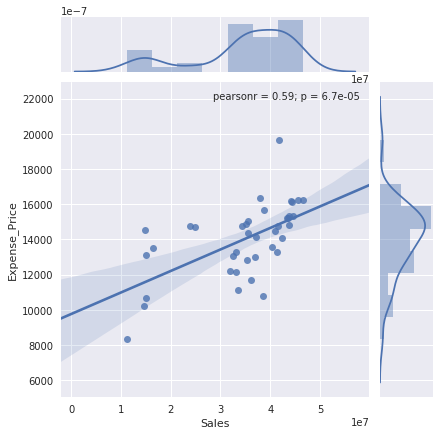

In [44]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Arg.query("Product_Type==1")["Expense_Price"])
df1["Sales"] = (Train_Arg.query("Product_ID==1")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

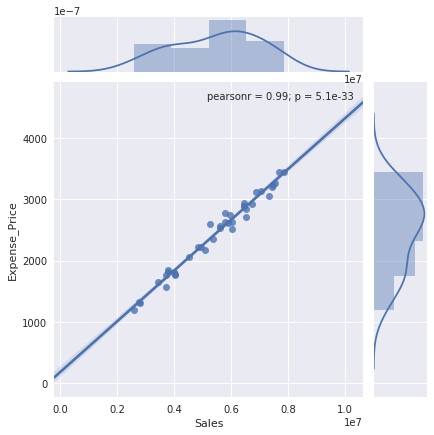

In [45]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Arg.query("Product_Type==2")["Expense_Price"])
df1["Sales"] = (Train_Arg.query("Product_ID==2")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

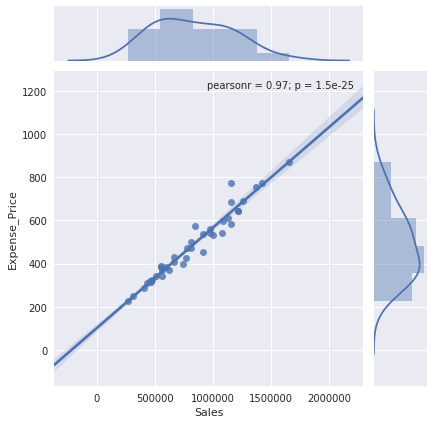

In [46]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Bel.query("Product_Type==2")["Expense_Price"])
df1["Sales"] = (Train_Bel.query("Product_ID==2")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

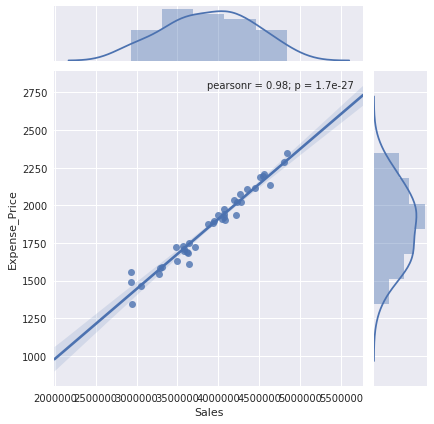

In [47]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Col.query("Product_Type==1")["Expense_Price"])
df1["Sales"] = (Train_Col.query("Product_ID==1")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

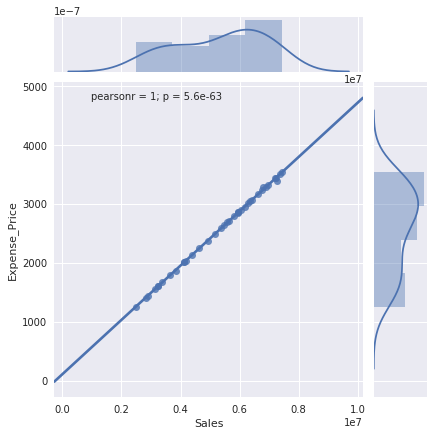

In [48]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Col.query("Product_Type==2")["Expense_Price"])
df1["Sales"] = (Train_Col.query("Product_ID==2")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

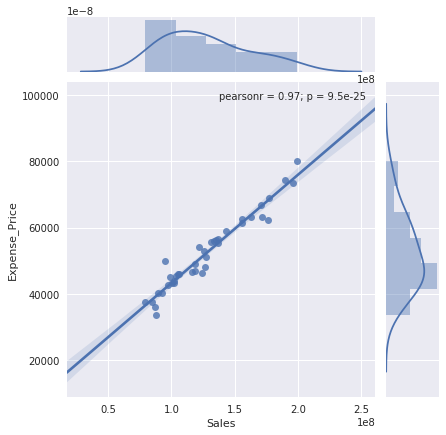

In [49]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Den.query("Product_Type==2")["Expense_Price"])
df1["Sales"] = (Train_Den.query("Product_ID==2")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

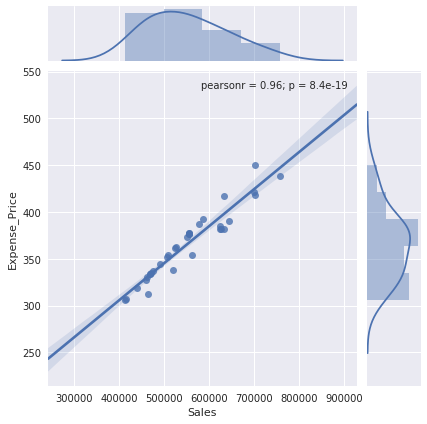

In [50]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Eng.query("Product_Type==5")["Expense_Price"])
df1["Sales"] = (Train_Eng.query("Product_ID==5")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

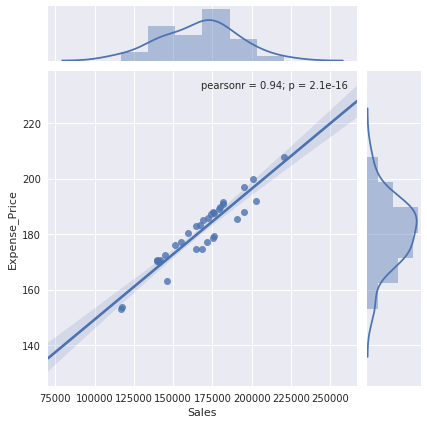

In [51]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Eng.query("Product_Type==4")["Expense_Price"])
df1["Sales"] = (Train_Eng.query("Product_ID==4")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

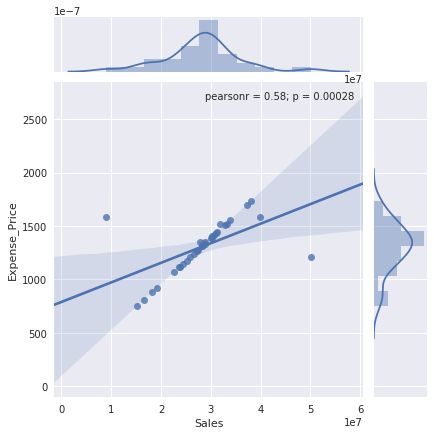

In [52]:
df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
df1["Expense_Price"] = (Exp_Fin.query("Product_Type==4")["Expense_Price"])
df1["Sales"] = (Train_Fin.query("Product_ID==4")["Sales"])
sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

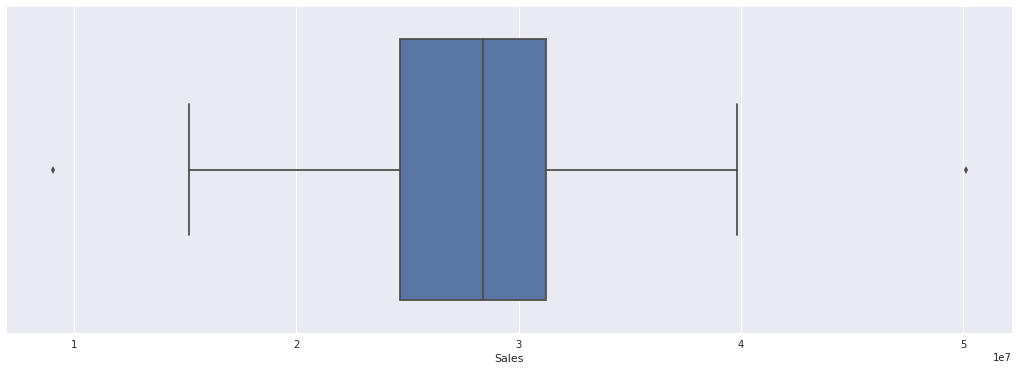

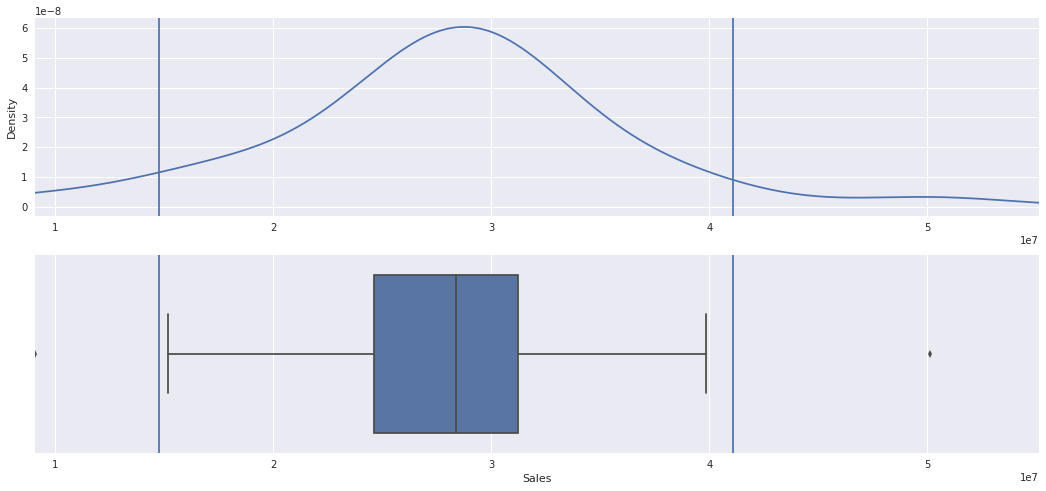

In [53]:
plt.figure(figsize=(18, 6))
sns.boxplot(df1["Sales"])
plt.show()

q75, q25 = np.percentile(df1.Sales.dropna(), [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)


i = 'Sales'
 
plt.figure(figsize=(18,8))
plt.subplot(211)
plt.xlim(df1[i].min(), df1[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = df1[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df1[i].min(), df1[i].max()*1.1)
sns.boxplot(x=df1[i])
plt.axvline(x=min)
plt.axvline(x=max)

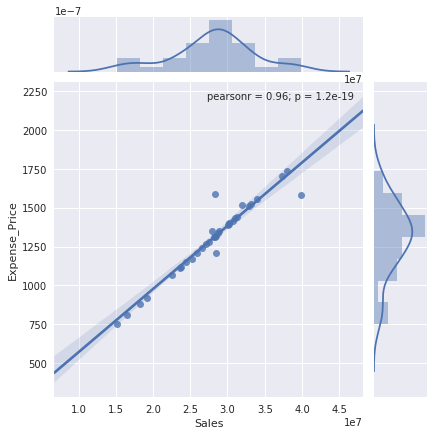

In [54]:
df1.loc[df1['Sales'] < min, 'Sales'] = df1["Sales"].median()
df1.loc[df1['Sales'] > max, 'Sales'] = df1["Sales"].median()

sns.jointplot("Sales", "Expense_Price", data=df1, kind="reg")
plt.show()

# MODEL

In [55]:
pred1 = []
pred2 = []
pred3 = []
pred4 = []
pred5 = []
pred6 = []
pred7 = []
pred8 = []
pred9 = []
pred10 = []
pred11 = []

In [56]:
reg = xgb(n_estimators=100,max_depth=3,seed=1729)

for i in range(1,12):
    if(i==1):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Arg.query("Product_Type==1")["Expense_Price"])
        df1["Sales"] = (Train_Arg.query("Product_ID==1")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:39]["Sales"]
        X_Tr = df1[:39]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[39:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred1 = reg.predict(X_Te)
        
    elif(i==2):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Arg.query("Product_Type==2")["Expense_Price"])
        df1["Sales"] = (Train_Arg.query("Product_ID==2")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:39]["Sales"]
        X_Tr = df1[:39]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[39:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred2 = reg.predict(X_Te)
        
    elif(i==3):
        model = ARIMA(Train_Arg.query("Product_ID==3")["Sales"], order=(5,0,1))
        model_fit = model.fit(disp=0)
        pred3 = model_fit.predict(start='2017-01-01',end='2017-03-01').reset_index(drop=True)

    elif(i==4):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Bel.query("Product_Type==2")["Expense_Price"])
        df1["Sales"] = (Train_Bel.query("Product_ID==2")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:39]["Sales"]
        X_Tr = df1[:39]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[39:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred4 = reg.predict(X_Te)
        
    elif(i==5):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Col.query("Product_Type==1")["Expense_Price"])
        df1["Sales"] = (Train_Col.query("Product_ID==1")["Sales"])
        
        q75, q25 = np.percentile(df1.Sales.dropna(), [75 ,25])
        iqr = q75 - q25
        min = q25 - (iqr*1.5)
        max = q75 + (iqr*1.5)
        
        df1.loc[df1['Sales'] < min, 'Sales'] = df1["Sales"].median()
        df1.loc[df1['Sales'] > max, 'Sales'] = df1["Sales"].median()
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:39]["Sales"]
        X_Tr = df1[:39]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[39:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred5 = reg.predict(X_Te)
        
    elif(i==6):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Col.query("Product_Type==2")["Expense_Price"])
        df1["Sales"] = (Train_Col.query("Product_ID==2")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:39]["Sales"]
        X_Tr = df1[:39]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[39:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred6 = reg.predict(X_Te)
        
    elif(i==7):
        model = ARIMA(Train_Col.query("Product_ID==3")["Sales"], order=(5,0,1))
        model_fit = model.fit(disp=0)
        pred7 = model_fit.predict(start='2017-01-01',end='2017-03-01').reset_index(drop=True)
        
    elif(i==8):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Den.query("Product_Type==2")["Expense_Price"])
        df1["Sales"] = (Train_Den.query("Product_ID==2")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:39]["Sales"]
        X_Tr = df1[:39]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[39:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred8 = reg.predict(X_Te)
        
    elif(i==9):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Eng.query("Product_Type==5")["Expense_Price"])
        df1["Sales"] = (Train_Eng.query("Product_ID==5")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:34]["Sales"]
        X_Tr = df1[:34]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[34:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred9 = reg.predict(X_Te)
        
    elif(i==10):
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Eng.query("Product_Type==4")["Expense_Price"])
        df1["Sales"] = (Train_Eng.query("Product_ID==4")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:34]["Sales"]
        X_Tr = df1[:34]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[34:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred10 = reg.predict(X_Te)
        
    else:
        df1 = pd.DataFrame(columns=["Sales","Expense_Price"])
        df1["Expense_Price"] = (Exp_Fin.query("Product_Type==4")["Expense_Price"])
        df1["Sales"] = (Train_Fin.query("Product_ID==4")["Sales"])
        
        df1 = df1.reset_index(drop=True)
        Y_Tr = df1[:34]["Sales"]
        X_Tr = df1[:34]
        X_Tr = X_Tr.drop(["Sales"], axis=1)
        X_Te = df1[34:]
        X_Te = X_Te.drop(["Sales"], axis=1)
        reg.fit(X_Tr,Y_Tr)
        pred11 = reg.predict(X_Te)
        

/home/firehawk/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/firehawk/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/firehawk/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [57]:
pred = []
pred.extend(pred1)
pred.extend(pred2)
pred.extend(pred3)
pred.extend(pred4)
pred.extend(pred5)
pred.extend(pred6)
pred.extend(pred7)
pred.extend(pred8)
pred.extend(pred9)
pred.extend(pred10)
pred.extend(pred11)

In [58]:
df_1 = pd.DataFrame(columns=["Sales"])
df_1["Sales"] = pred
TestData = pd.read_csv(TestDataPath)
TestData["Sales"] = df_1["Sales"]
TestData.to_csv('yds_submission2018.csv', index = False)